# create tweets.csv

In [ ]:
# #@title Download Kaggle API token from Google Drive
# import gdown
# import os
# from pathlib import Path

# gdrive_url = 'https://drive.google.com/uc?id=1P6t7O8vOjmQi3rMX0KQlgO6BT0fk2dI-'
# if not os.path.exists('kaggle.json'):
#   gdown.download(gdrive_url, 'kaggle.json', quiet=False)

# kaggle_dir = Path.home() / '.kaggle'
# kaggle_token_path = kaggle_dir / 'kaggle.json'

# if not kaggle_token_path.exists():
#   kaggle_dir.mkdir(parents=True, exist_ok=True)
#   os.rename('kaggle.json', kaggle_token_path)
#   kaggle_token_path.chmod(0o600)

# dataset_path = 'global_covid-19'
# if not os.path.exists(dataset_path):
#   os.mkdir(dataset_path)
#   !kaggle datasets download -d rohitashchandra/global-covid19-twitter-dataset --path {dataset_path} --unzip
#   gdrive_url = 'https://drive.google.com/uc?id=19Hr0PQSyqGqLLJlPaDKjMfvlbFVnYbBr'
#   os.remove(os.path.join(dataset_path, 'India.csv'))
#   gdown.download(gdrive_url, os.path.join(dataset_path, 'India.csv'), quiet=False)

In [2]:
from csv import QUOTE_NONE
import os
import pandas as pd
import random
import csv
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from geopy.geocoders import Nominatim
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
#@title merge into one csv

# List to hold the dataframes
dataframes = []
dataset_dir = 'global_covid-19'
dataset = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir)]
# Read each CSV file with specific settings to handle quoting issues
for data in dataset:
  try:
    # Open the file with utf-8 encoding, handle errors by replacing problematic characters
    with open(data, 'r', encoding='utf-8', newline='') as file:
      df = pd.read_csv(file, on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL)
      df = df.iloc[:, 1:]
  except UnicodeDecodeError:
    # Fallback to a different encoding if UTF-8 doesn't work
    with open(data, 'r', encoding='ISO-8859-1', newline='') as file:
      df = pd.read_csv(file, on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL)
      df = df.iloc[:, 1:]
  dataframes.append(df)
  random_rows = df.sample(n=3)
  # Display the random rows
  print(f"Random rows from {data}:")
  display(random_rows)

# Concatenate all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

tweets_file = 'tweets.csv'

# Save the combined dataframe to a new CSV file
combined_df.to_csv(tweets_file, index=False)

# open and sample 20 rows from tweets.csv
df = pd.read_csv(tweets_file)
random_rows = df.sample(n=20)
print(f"Random rows from {tweets_file}:")
display(random_rows)

Random rows from global_covid-19\Australia.csv:


,created_at,text,user_location
219775,Fri Dec 31 17:35:25 +0000 2021,@SkySportsNews Why are people so upset about p...,Nottingham
193455,Fri Dec 31 05:58:13 +0000 2021,Senate GOP preps to nullify Biden’s vaccine ma...,Jerusalem | Washington D.C.
379195,Wed Dec 15 10:28:37 +0000 2021,RT @KittyAbsurd: Has any journo questioned the...,East Nowra New South Wales


Random rows from global_covid-19\Brazil.csv:


,created_at,text,user_location
335014,Fri Mar 05 17:28:32 +0000 2021,RT @VP: A third safe and effective vaccine is ...,Panama city
237616,Sat Aug 07 04:40:40 +0000 2021,RT @DrEricDing: PAY ATTENTION—the #DeltaVarian...,Mundo | Argentina | Europa
312129,Sat Feb 27 01:13:47 +0000 2021,RT @AllyBrooke: 5 years since #WorkFromHome wa...,"Acaiaca, Brasil"


Random rows from global_covid-19\Indonesia.csv:


,created_at,text,user_location
87864,Sat Mar 06 04:18:11 +0000 2021,RT @jiggyjayy2: Yall cannot continuously atten...,Indonesia
31635,Fri Dec 24 08:32:02 +0000 2021,Indonesia Adds Quarantine Wards to Anticipate ...,"Jakarta, Indonesia"
185622,Fri Dec 24 23:04:20 +0000 2021,RT @soompi: BTS' Suga Diagnosed With COVID-19\...,Indonesia


Random rows from global_covid-19\Japan.csv:


,created_at,text,user_location
390298,Mon Aug 30 10:42:08 +0000 2021,@smolyoongiiii covid get the hell out,"Kaizuka-shi, Osaka"
383520,Thu Apr 15 13:32:59 +0000 2021,RT @jaybeeyxe: A member of my wife’s family di...,Trinidad and Tobago
34241,Fri Dec 24 08:38:50 +0000 2021,RT @SeanGoss31: The vaccine rollout has come t...,"Greenstone Hill, south africa"


Random rows from tweets.csv:


,created_at,text,user_location
1024220,1351108980140077058,RT @BT21_: Happiest when we're together. ❤️\n\...,"Central Java, Indonesia"
783725,Thu Mar 18 01:41:03 +0000 2021,RT @NYHammond: New post:\n\nThe Cuomo administ...,Lurking in the Potential
556564,Fri Dec 24 14:18:18 +0000 2021,RT @brat2381: I keep trying to tell folks to w...,"Houston, TX; Copenhagen, DK"
1405515,Thu Mar 25 00:58:24 +0000 2021,@trinijournalist Really feeling this 3rd world...,Trinidad and Tobago
792173,Sat May 01 09:17:27 +0000 2021,The United States Provides Additional Funding ...,"Butwal, Nepal / Ex Sao Paulo"
253881,Sun Jan 02 12:52:40 +0000 2022,"RT @JNkengasong: Two years,&lt;100 cases of th...","Adelaide, South Australia"
80013,Fri Dec 24 14:19:41 +0000 2021,RT @PeterWMurphy1: Remember: No one from the F...,"Perth, Western Australia"
109776,Mon Dec 27 08:30:35 +0000 2021,@catherine___c It’s almost like a pandemic cha...,"Queensland, Australia"
1268474,Mon Feb 08 12:43:44 +0000 2021,Enterprise hits and misses - taking stock of A...,"Hannover, Germany"
203777,Fri Dec 31 09:16:10 +0000 2021,RT @RageSheen: A short thread on the magnitude...,"Darwin, Northern Territory"


# read tweets.csv

In [58]:
df = pd.read_csv('tweets.csv')
df = df.dropna()
df.sample(10)

,created_at,text,user_location
92006,Fri Dec 24 22:52:44 +0000 2021,RT @MaajidNawaz: None of you are merely “disag...,"Brisbane, Queensland"
1076850,Fri Dec 24 16:18:09 +0000 2021,Omicron’s cold-like symptoms mean UK guidance ...,"Folkestone, England"
904138,Mon Feb 22 09:08:14 +0000 2021,RT @ASEAN: The latest edition of the Column hi...,"Jakarta, Indonesia"
794134,Mon May 03 07:02:53 +0000 2021,RT @Itsss_Shivam: More than quality its bad lu...,Bhubaneshwar
826158,Sat May 08 07:56:16 +0000 2021,RT @vijayanpinarayi: It is unfortunate that at...,Mangalore
975623,Tue Sep 07 03:11:54 +0000 2021,Just focus on the soles🥺 https://t.co/rtjKsparW1,"Sleman, Indonesia"
389361,Wed Dec 15 17:09:34 +0000 2021,State of it. Watford will already be halfway ...,Warwick Uni Real Ale Festival
216349,Fri Dec 31 15:17:50 +0000 2021,@lflfilipe I have a 4 year old due back in JK ...,"Hamilton, Ontario"
998494,Fri Nov 19 09:34:42 +0000 2021,RT @SkyNews: COVID-19: Austria to enter full n...,"Puerto Moresby,Papua"
386144,Wed Dec 15 14:29:23 +0000 2021,RT @denise_dewald: Mini-lesson on why ALL lowe...,"Sydney, Australia"


In [59]:
# Assuming df is your DataFrame
df['text'] = df['text'].astype(str)
# Remove URLs
df['cleaned_text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
# Remove mentions
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'@\w+', '', x))
# Remove hashtags
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'#\w+', '', x))
# Remove punctuation
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
# Remove stop words
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
# Remove 'RT'
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() != 'rt']))
# Tokenize text
df['tokens'] = df['cleaned_text'].apply(word_tokenize)
# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [60]:
def is_valid_date(date_str):
    try:
        pd.to_datetime(date_str)
        return True
    except (ValueError, OverflowError):
        return False

# Count and drop invalid dates
def count_and_drop_invalid_dates(df, column):
    # Identify valid dates
    valid_dates = df[column].apply(is_valid_date)
    
    # Count invalid dates
    invalid_date_count = (~valid_dates).sum()
    
    # Drop rows with invalid dates
    df_valid = df[valid_dates].reset_index(drop=True)
    
    return df_valid, invalid_date_count

# Apply the function
df, invalid_date_count = count_and_drop_invalid_dates(df, 'created_at')

print(f"Number of rows with invalid dates: {invalid_date_count}")

# Display the processed DataFrame
print("Processed DataFrame without invalid dates:")
display(df.sample(10))

Number of rows with invalid dates: 23682
Processed DataFrame without invalid dates:


,created_at,text,user_location,cleaned_text,tokens
1293250,Fri Mar 05 15:12:07 +0000 2021,"RT @bkives: If more shipments arrive earlier, ...","Portage la Prairie, Manitoba",If shipments arrive earlier everyone aged 18 g...,"[If, shipment, arrive, earlier, everyone, aged..."
278321,Sun Jan 02 23:30:52 +0000 2022,RT @jillastark: Things Scott Morrison will hap...,"Victoria, Australia",Things Scott Morrison happily give free 💰schoo...,"[Things, Scott, Morrison, happily, give, free,..."
876985,Wed Aug 25 11:10:35 +0000 2021,The UN is calling for support from private sec...,"Jakarta, Indonesia",The UN calling support private sectors protect...,"[The, UN, calling, support, private, sector, p..."
154139,Wed Dec 29 07:26:26 +0000 2021,RT @drkerrynphelps: It will become increasingl...,Sydney,It become increasingly obvious NSW government ...,"[It, become, increasingly, obvious, NSW, gover..."
1445153,Mon Sep 06 15:42:47 +0000 2021,RT @jbsuperman: Unvaccinated people not being ...,Trinidad and Tobago,Unvaccinated people allowed schools churches b...,"[Unvaccinated, people, allowed, school, church..."
311902,Mon Nov 29 10:58:14 +0000 2021,RT @PaulMeekPerth: One of the covid positive c...,"Melbourne, Victoria",One covid positive cases partner Netherlands f...,"[One, covid, positive, case, partner, Netherla..."
305539,Mon Nov 29 06:53:38 +0000 2021,@ganonaintabaddy @AndyMeddickMP We were under ...,"Melbourne, Victoria",We 23 hour lockdown earlier year removed If yo...,"[We, 23, hour, lockdown, earlier, year, remove..."
365338,Wed Dec 15 04:29:03 +0000 2021,not having to wear a mask in public feels so W...,SYDNEY,wear mask public feels WEIRD,"[wear, mask, public, feel, WEIRD]"
153620,Wed Dec 29 07:15:28 +0000 2021,Requesting permission to slap the skin off any...,Sydney,Requesting permission slap skin anyone says ri...,"[Requesting, permission, slap, skin, anyone, s..."
941960,Sat May 08 09:44:41 +0000 2021,RT @HausofHilton: Another vaccinated healthcar...,"Batu Pahat, Johor",Another vaccinated healthcare staff sharing pr...,"[Another, vaccinated, healthcare, staff, shari..."


In [61]:

df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
df['day_of_week'] = df['created_at'].dt.dayofweek
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year


In [62]:
df['text_length'] = df['cleaned_text'].apply(len)


In [77]:
df.head().style.hide(axis='index')

created_at,text,user_location,cleaned_text,tokens,day_of_week,month,year,text_length
2021-12-08 04:25:46+00:00,"RT @AaronSiriSG: Litigation update: FDA doubles down, asking federal judge to grant it until at least 2096 to fully release Pfizer’s COV…","Iasi, Romania",Litigation update FDA doubles asking federal judge grant least 2096 fully release Pfizer’s COV…,"['Litigation', 'update', 'FDA', 'double', 'asking', 'federal', 'judge', 'grant', 'least', '2096', 'fully', 'release', 'Pfizer', '’', 's', 'COV…']",2,12,2021,95
2021-12-08 04:25:57+00:00,"RT @covidbaseau: The TGA has approved the Moderna vaccine for booster doses for those aged 18 and older, at least 6 months after a second d…",Canberra,The TGA approved Moderna vaccine booster doses aged 18 older least 6 months second d…,"['The', 'TGA', 'approved', 'Moderna', 'vaccine', 'booster', 'dos', 'aged', '18', 'older', 'least', '6', 'month', 'second', 'd…']",2,12,2021,85
2021-12-08 04:26:06+00:00,"RT @SimoLove: Federal Health Minister Greg Hunt: ""We're well used to hotspots.. now in NSW its a much smaller circle in terms of close cont…","Wurundjeri Richmond, Melbourne",Federal Health Minister Greg Hunt Were well used hotspots NSW much smaller circle terms close cont…,"['Federal', 'Health', 'Minister', 'Greg', 'Hunt', 'Were', 'well', 'used', 'hotspot', 'NSW', 'much', 'smaller', 'circle', 'term', 'close', 'cont…']",2,12,2021,99
2021-12-08 04:26:07+00:00,@twityouse Are these the deniers that are wearing “if I get sick from Covid never take me to a doctor or hospital” bracelets?,"Victoria, Australia",Are deniers wearing “if I get sick Covid never take doctor hospital” bracelets,"['Are', 'denier', 'wearing', '“', 'if', 'I', 'get', 'sick', 'Covid', 'never', 'take', 'doctor', 'hospital', '”', 'bracelet']",2,12,2021,78
2021-12-08 04:26:07+00:00,RT @drsimonegold: WOW: a preprint study for The Lancet shows protection from the Covid shots declines severely after only a few months—and…,Perth WA,WOW preprint study The Lancet shows protection Covid shots declines severely months—and…,"['WOW', 'preprint', 'study', 'The', 'Lancet', 'show', 'protection', 'Covid', 'shot', 'decline', 'severely', 'months—and…']",2,12,2021,88


In [74]:
df.sample(10).style.hide(axis='index')

created_at,text,user_location,cleaned_text,tokens,day_of_week,month,year,text_length
2021-03-27 02:05:50+00:00,RT @jmcmaster29: 4% of nurses in the United States are Filipino. 32% of nurses lost to COVID-19 in the United States have been Filipino.…,Tokyo,4 nurses United States Filipino 32 nurses lost COVID19 United States Filipino…,"['4', 'nurse', 'United', 'States', 'Filipino', '32', 'nurse', 'lost', 'COVID19', 'United', 'States', 'Filipino…']",5,3,2021,78
2021-03-28 07:40:54+00:00,RT @americanamemes: Me BEFORE Me AFTER the vaccine: the vaccine: https://t.co/McBQDdPVhC,Osaka,Me BEFORE Me AFTER vaccine vaccine,"['Me', 'BEFORE', 'Me', 'AFTER', 'vaccine', 'vaccine']",6,3,2021,34
2021-05-03 06:54:21+00:00,Ask LP: What countries can I travel to if I’ve had the COVID-19 vaccine? https://t.co/MFGCvXmMjS @lonelyplanet,Taiwan,Ask LP What countries I travel I’ve COVID19 vaccine,"['Ask', 'LP', 'What', 'country', 'I', 'travel', 'I', '’', 've', 'COVID19', 'vaccine']",0,5,2021,51
2021-12-17 15:53:26+00:00,"RT @LynzforCongress: Life in a failed, one-party state: ▪️Political judge makes rulings that benefit the party ▪️So the AG can falsely cl…",Missouree,Life failed oneparty state ▪️Political judge makes rulings benefit party ▪️So AG falsely cl…,"['Life', 'failed', 'oneparty', 'state', '▪️Political', 'judge', 'make', 'ruling', 'benefit', 'party', '▪️So', 'AG', 'falsely', 'cl…']",4,12,2021,92
2020-05-01 18:48:02+00:00,RT @MbalulaFikile: Window period to travel home: 1 May 2020 and 7 May 2020 Long distance bus and taxi operators are allowed to undertake…,"Mpumalanga, South Africa",Window period travel home 1 May 2020 7 May 2020 Long distance bus taxi operators allowed undertake…,"['Window', 'period', 'travel', 'home', '1', 'May', '2020', '7', 'May', '2020', 'Long', 'distance', 'bus', 'taxi', 'operator', 'allowed', 'undertake…']",4,5,2020,99
2021-12-06 06:43:21+00:00,RT @davidlipson: A fascinating afternoon on the ground in Warringah - Vast majority of people I spoke to still LOVE Gladys Berejiklian. -…,"Sydney, New South Wales",A fascinating afternoon ground Warringah Vast majority people I spoke still LOVE Gladys Berejiklian …,"['A', 'fascinating', 'afternoon', 'ground', 'Warringah', 'Vast', 'majority', 'people', 'I', 'spoke', 'still', 'LOVE', 'Gladys', 'Berejiklian', '…']",0,12,2021,101
2022-01-02 20:55:22+00:00,"What's your New Years Resolution for 2022? I'm investing time in my garden, reading and making sense of this once in a lifetime world situation. For that's what it is. A once in a lifetime world situation. This book delivers imho. Follow the science. https://t.co/UWuQO9E9dY https://t.co/FNxuue2fzw https://t.co/ETiHd6sCve","Koroit, Victoria",Whats New Years Resolution 2022 Im investing time garden reading making sense lifetime world situation For thats A lifetime world situation This book delivers imho Follow science,"['Whats', 'New', 'Years', 'Resolution', '2022', 'Im', 'investing', 'time', 'garden', 'reading', 'making', 'sense', 'lifetime', 'world', 'situation', 'For', 'thats', 'A', 'lifetime', 'world', 'situation', 'This', 'book', 'delivers', 'imho', 'Follow', 'science']",6,1,2022,178
2022-01-02 22:01:43+00:00,RT @australian: Nursing staff at a leading Sydney hospital have been asked to accept cash incentives to cancel their annual leave due to “c…,"Queensland, Australia",Nursing staff leading Sydney hospital asked accept cash incentives cancel annual leave due “c…,"['Nursing', 'staff', 'leading', 'Sydney', 'hospital', 'asked', 'accept', 'cash', 'incentive', 'cancel', 'annual', 'leave', 'due', '“', 'c…']",6,1,2022,94
2021-05-07 04:28:00+00:00,"According to a fact sheet issued by the State Department on January 21, 2021, “The U.S. government has reason to believe that several researchers inside the WIV became sick in autumn 2019, before the first identified case of the outbreak, with symptoms consistent with COVID-19” https://t.co/6SsVVVtUkt","Las Condes, Chile",According fact sheet issued State Department January 21 2021 “The US 

In [64]:
# Load and prepare the lexicon

lexicon_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
lexicon_url = 'https://drive.google.com/file/d/1DPFWNXD3DnyYH2flofh3oXsAr38VCJY9/view?usp=drive_link'
if not os.path.exists(lexicon_path):
  import gdown
  gdown.download(lexicon_url, lexicon_path, fuzzy=True)

lexicon = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', names=['word', 'emotion', 'association'])
lexicon_pivot = lexicon.pivot(index='word', columns='emotion', values='association').fillna(0)
lexicon_pivot.index = lexicon_pivot.index.map(str)  # Ensure index is all strings
vocabulary_dict = {word: i for i, word in enumerate(lexicon_pivot.index)}

In [65]:
df = df.dropna()

# Define a more nuanced emotion mapping
emotion_mapping = {
    'anger': ['anger'],
    'fear': ['fear'],
    'joy': ['joy'],
    'worried': ['fear', 'sadness'],
    'sadness': ['sadness'],
    'disgust': ['disgust'],
    'trust': ['trust'],
    'anticipation': ['anticipation'],
    'anxiety': ['fear', 'anticipation', 'negative']  # New definition for anxiety
}

# Vectorize tweets
vectorizer = CountVectorizer(vocabulary=vocabulary_dict)
df['cleaned_text'] = df['cleaned_text'].fillna('').astype(str)
tweet_matrix = vectorizer.fit_transform(df['cleaned_text'])

In [27]:
# Calculate emotion scores
emotion_scores = np.zeros((df.shape[0], len(emotion_mapping)))

for i, (category, emotions) in enumerate(emotion_mapping.items()):
    indices = np.array([lexicon_pivot.columns.get_loc(emotion) for emotion in emotions if emotion in lexicon_pivot.columns])
    emotion_scores[:, i] += tweet_matrix.dot(lexicon_pivot.iloc[:, indices].sum(axis=1))

# Normalize scores
emotion_scores_sum = emotion_scores.sum(axis=1, keepdims=True)
emotion_scores = np.where(emotion_scores_sum > 0, emotion_scores / emotion_scores_sum, 0)

# Assign the dominant emotion
dominant_emotion = pd.DataFrame(emotion_scores, columns=emotion_mapping.keys()).idxmax(axis=1)
df['emotion'] = np.where(emotion_scores_sum.squeeze() > 0, dominant_emotion, 'neutral')  # Default to 'neutral'

# Save results
df.to_csv('labeled_tweets.csv', index=False)

C:\Users\duterte\AppData\Local\Temp\ipykernel_10852\2108236899.py:10: RuntimeWarning: invalid value encountered in divide
  emotion_scores = np.where(emotion_scores_sum > 0, emotion_scores / emotion_scores_sum, 0)


In [28]:
# Calculate the number of non-zero entries in the vectorized matrix
non_zero_matrix_entries = np.count_nonzero(tweet_matrix.sum(axis=1))

# Calculate the percentage of tweets with non-zero entries
percentage_non_zero = (non_zero_matrix_entries / df.shape[0]) * 100
print(f"Percentage of tweets containing lexicon words: {percentage_non_zero}%")

Percentage of tweets containing lexicon words: 95.46370967741935%


In [30]:
# Check the raw emotion scores for a random sample of tweets
sample_scores = pd.DataFrame(emotion_scores, columns=emotion_mapping.keys())
print("Sample emotion scores:")
display(sample_scores.sample(10))


Sample emotion scores:


,anger,fear,joy,worried,sadness,disgust,trust,anticipation,anxiety
204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
969,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
453,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
977,0.086957,0.130435,0.086957,0.173913,0.043478,0.086957,0.086957,0.043478,0.260870
868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
348,0.000000,0.166667,0.000000,0.333333,0.166667,0.000000,0.000000,0.000000,0.333333
471,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.500000
58,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# run these if labeled_tweets.csv does not need preprocessing

In [1]:
import os
import pandas as pd

labeled_path = 'labeled_tweets.csv'
labeled_url = 'https://drive.google.com/file/d/1ujlio9DSynMNkv-ORxTz1He8dUaL2cWH/view?usp=sharing'
if not os.path.exists(labeled_path):
  import gdown
  gdown.download(labeled_url, labeled_path, fuzzy=True)

labeled_df = pd.read_csv(labeled_path)


In [2]:
labeled_df.sample(10)[['cleaned_text','tokens']].style.hide(axis='index')

cleaned_text,tokens
Purim Jewish Holiday Carnival Cute Clown Pattern Premium Face Mask …,"['Purim', 'Jewish', 'Holiday', 'Carnival', 'Cute', 'Clown', 'Pattern', 'Premium', 'Face', 'Mask', '…']"
Tokyo reports 316 new COVID19 cases emergency extension eyed,"['Tokyo', 'report', '316', 'new', 'COVID19', 'case', 'emergency', 'extension', 'eyed']"
When COVID hit came plan immediately Safe say staff executed plan per…,"['When', 'COVID', 'hit', 'came', 'plan', 'immediately', 'Safe', 'say', 'staff', 'executed', 'plan', 'per…']"
Happy Thursday That day COVID tends to📈📈 855AM We wait,"['Happy', 'Thursday', 'That', 'day', 'COVID', 'tends', 'to📈📈', '855AM', 'We', 'wait']"
This ridiculous The Asian community suffering rise hate crimes due pandemic locally glob…,"['This', 'ridiculous', 'The', 'Asian', 'community', 'suffering', 'rise', 'hate', 'crime', 'due', 'pandemic', 'locally', 'glob…']"
First findings world’s largest study long Covid children shows 14 get long covid still suffering 15 weeks4 month…,"['First', 'finding', 'world', '’', 's', 'largest', 'study', 'long', 'Covid', 'child', 'show', '14', 'get', 'long', 'covid', 'still', 'suffering', '15', 'weeks4', 'month…']"
Breakthrough based team led identifies potential genetic marker patients wil…,"['Breakthrough', 'based', 'team', 'led', 'identifies', 'potential', 'genetic', 'marker', 'patient', 'wil…']"
𝗜 𝗱𝗼𝗻𝘁 𝘄𝗮𝗻𝘁 𝘁𝗼 𝘀𝗲𝗲 𝘆𝗼𝘂 𝗴𝗲𝘁 𝘀𝗶𝗰𝗸 𝗪𝗵𝗮𝘁 𝘆𝗼𝘂 𝗴𝗼𝗻𝗻𝗮 𝗱𝗼 𝗗𝗼𝗻𝘁 𝗵𝗲𝘀𝗶𝘁𝗮𝘁𝗲,"['𝗜', '𝗱𝗼𝗻𝘁', '𝘄𝗮𝗻𝘁', '𝘁𝗼', '𝘀𝗲𝗲', '𝘆𝗼𝘂', '𝗴𝗲𝘁', '𝘀𝗶𝗰𝗸', '𝗪𝗵𝗮𝘁', '𝘆𝗼𝘂', '𝗴𝗼𝗻𝗻𝗮', '𝗱𝗼', '𝗗𝗼𝗻𝘁', '𝗵𝗲𝘀𝗶𝘁𝗮𝘁𝗲']"
If Covid booming midst summer r going control winter I couldn’t handle another fucked footy season,"['If', 'Covid', 'booming', 'midst', 'summer', 'r', 'going', 'control', 'winter', 'I', 'couldn', '’', 't', 'handle', 'another', 'fucked', 'footy', 'season']"
I’m tired told fear covid people without science health background actual scientists a…,"['I', '’', 'm', 'tired', 'told', 'fear', 'covid', 'people', 'without', 'science', 'health', 'background', 'actual', 'scientist', 'a…']"


In [3]:
labeled_df.iloc[877369]

created_at       2021-12-24 13:22:18+00:00
text              RT @jmojig: FUCK U COVID
user_location          Karawang, Indonesia
cleaned_text                  FUCK U COVID
tokens              ['FUCK', 'U', 'COVID']
day_of_week                              4
month                                   12
year                                  2021
text_length                             12
emotion                            neutral
Name: 877369, dtype: object

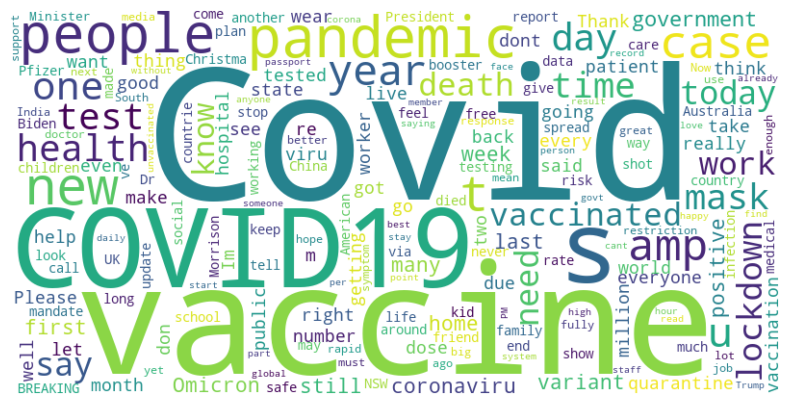

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into a single string
labeled_df['cleaned_text'] = labeled_df['cleaned_text'].astype(str)
text = " ".join(review for review in labeled_df.cleaned_text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [6]:
X = labeled_df['cleaned_text']
y = labeled_df['emotion']

vectorizer = TfidfVectorizer()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text vectorization
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)  # Fit and transform on training data
X_test_vec = vectorizer.transform(X_test)  # Transform the test data

              precision    recall  f1-score   support

       anger       0.96      0.86      0.90      7163
anticipation       0.95      0.94      0.95     12414
     anxiety       0.98      0.96      0.97     97162
     disgust       0.95      0.72      0.82      1855
        fear       0.95      0.94      0.94      5453
         joy       0.95      0.94      0.94     20235
     neutral       0.94      1.00      0.97     72350
       trust       0.96      0.95      0.95     40430
     worried       0.97      0.96      0.96     40257

    accuracy                           0.96    297319
   macro avg       0.96      0.92      0.93    297319
weighted avg       0.96      0.96      0.96    297319



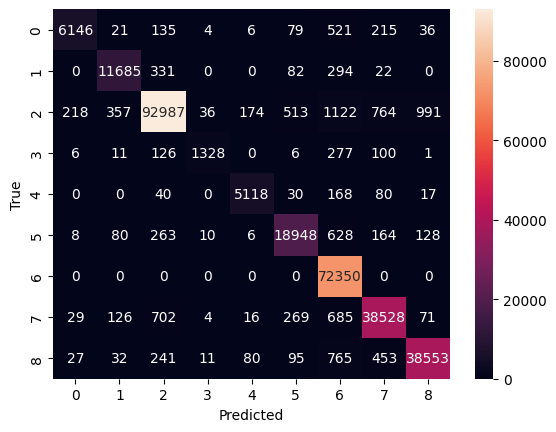

In [7]:
# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Predict
y_pred = model.predict(X_test_vec)

# Evaluation
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

              precision    recall  f1-score   support

       anger       0.89      0.77      0.83      7163
anticipation       0.86      0.82      0.84     12414
     anxiety       0.88      0.91      0.90     97162
     disgust       0.95      0.73      0.82      1855
        fear       0.90      0.85      0.87      5453
         joy       0.90      0.83      0.86     20235
     neutral       0.90      0.99      0.94     72350
       trust       0.91      0.84      0.87     40430
     worried       0.93      0.84      0.88     40257

    accuracy                           0.90    297319
   macro avg       0.90      0.84      0.87    297319
weighted avg       0.90      0.90      0.90    297319



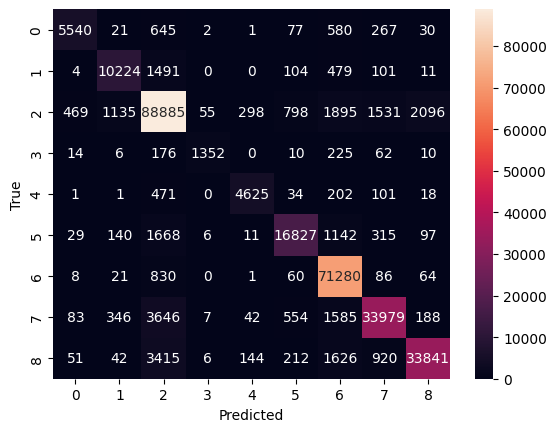

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the model
rf_model.fit(X_train_vec, y_train)

# Predict
y_pred = rf_model.predict(X_test_vec)

# Evaluation
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()